# D2Q9

Mainly code reference : https://youtu.be/JFWqCQHg-Hs. But I think his main loop has a wrong execution order.

![alt text](figs/d2q9.svg)

### Lattice Bolztmann Equation(LBE):

Consider the Boltzmann Equation  

$$
\partial_{t}f + \vec{\xi}\cdot \nabla f = \Omega[f,f]
$$  

Consider integrating the following total differential using the **trapezoidal rule** (or equivalently, interpreting it as the improved Euler method for solving ordinary differential equations):  

$$
\frac{\mathrm{d}}{\mathrm{d} \Delta t}f(\vec x + \vec{\xi}\Delta t, \vec{\xi}, t + \Delta t) = \partial_{t}f + \vec{\xi}\cdot \nabla f = \Omega[f,f]
$$  

This yields:  

$$
f(\vec x + \vec{\xi} \Delta t, \vec{\xi}, t + \Delta t) - f(\vec x, \vec{\xi}, t) = \frac{\Delta t}{2}\left[ \Omega(\vec x + \vec{\xi} \Delta t, \vec{\xi}, t + \Delta t) + \Omega(\vec x, \vec{\xi}, t) \right]
$$  

This is an implicit method... right?  

Moving the terms involving \(\Delta t\) on the right-hand side to the left and combining them with the terms involving \(\Delta t\), we define:  

$$
\bar f = f - \frac{\Delta t}{2}\Omega[f,f] = f - \frac{\Delta t}{2\tau}(f^{\text{eq}} - f) = \frac{(2\tau + \Delta t)f - \Delta t\,f^{\text{eq}}}{2\tau}
$$  

After rearrangement, we obtain:  

$$
\bar f(\vec x + \vec{\xi}\Delta t, \vec{\xi}, t + \Delta t) - \bar f(\vec x, \vec{\xi}, t) = \frac{f^{\text{eq}}(\vec x, \vec{\xi}, t) - \bar f(\vec x, \vec{\xi}, t) }{\tau'},
$$

where
- $\tau' = \frac{\tau}{\Delta t} + \frac{1}{2}$ is a constant dimensionless number if we consider a isothermal case with a constant kinematic viscosity model;
- $f^{\text{eq}}$ is the equlibrium distribution that $f$ relaxing to.

By selecting an appropriate time step $\Delta t$ and a finite set of discrete velocity points $\{\vec{\xi}_\alpha\}$, we can construct a computational mesh with the following property: for any vertex $\vec{x}_i$ in the mesh, all points $\vec{x}_i + \vec{\xi}_{\alpha}\Delta t$ coincide with other mesh vertices. This special property enables us to predict the evolution of the distribution functions at the mesh vertices and the discrete velocity points using only information from the previous time step. 

### D2Q9 Scheme

Now the iterations begins. we take  the D2Q9 model, which is a 2D structured grid with 9 velocity directions.

![alt text](figs/d2q9.svg)

The distance of discrete velocities denoted as $\tilde{\xi}$, thus we have
$$
\begin{aligned}
\vec{\xi}_{0}/\tilde{\xi} &= (0, 0) := (I_0, J_0) &\\
\vec{\xi}_{1}/\tilde{\xi} &= (0, 1) := (I_1, J_1) & \vec{\xi}_{5}/\tilde{\xi} &= (1, 1) := (I_5, J_5) \\
\vec{\xi}_{2}/\tilde{\xi} &= (1, 0) := (I_2, J_2) & \vec{\xi}_{6}/\tilde{\xi} &= (-1, 1) := (I_6, J_6) \\
\vec{\xi}_{3}/\tilde{\xi} &= (0, -1) := (I_3, J_3) & \vec{\xi}_{7}/\tilde{\xi} &= (-1, -1) := (I_7, J_7) \\
\vec{\xi}_{4}/\tilde{\xi} &= (-1, 0) := (I_4, J_4) & \vec{\xi}_{8}/\tilde{\xi} &= (1, -1) := (I_8, J_8) \\
\end{aligned}
$$
and $\tilde{\xi} \Delta t = \Delta x$.

Let's define $f^{n}_{ij\alpha} = f(\vec{x}_{ij}, \vec{\xi}_\alpha, t^n)$, then LBE becomes
$$
\bar f^{n+1}_{i + I_\alpha, j + J_\alpha, \alpha} = \bar f^{n}_{ij\alpha} + \frac{(f^{\text{eq}})^{n}_{ij\alpha} - \bar f^{n}_{ij\alpha}}{\tau'}
$$

### Discrete Distribution Functions and Quadrature

The problem now, is how to get $f^{\text{eq}}_{ij\alpha}$. They are functions of macroscopic variables, $\rho$ and $\vec{u}$. If we have the distribution function over the whole momentum space, we can compute the macroscopic variables by doing integration. 

$$
\begin{gathered}
  \int {\rm d} \vec{\xi}~ f = \rho \\
  \int {\rm d} \vec{\xi}~ \vec{\xi} f = \rho \vec{u} \\
  f^{\text{eq}} = \frac{\rho}{(2\pi m k_{\rm B}T)^{D/2}}\exp\left[ -\frac{m(\vec{\xi}- \vec{u})^{2}}{2k_{\rm B}T}\right ]
\end{gathered}
$$

Now we only have finitely many discrete velocity in the momentum space, we can use the quadrature method to approximate the integrals. Because we are doing the quadrature in a infinite space, the whole momentum space $\mathbb{R}^D$, We need an appropriate weight function.

Given the weight function 
$$
\omega(\vec{\xi}) = \frac{1}{(2\pi m k_{\rm B}T)^{D/2}}\exp\left[ -\frac{m\vec{\xi}^{2}}{2k_{\rm B}T}\right],
$$
the quadrature formula for a function $g(\vec{\xi})$ is
$$
\int {\rm d}\vec{\xi} \omega(\vec{\xi}) g(\vec{\xi}) = \sum_{i}^{N} \omega_i g(\vec{\xi}_i)
$$

Applying to the distribution function:
$$
\begin{aligned}
	\int {\rm d} \vec{\xi}~ f(\vec{\xi})q(\vec{\xi}) & = \int {\rm d} \vec{\xi}~ \omega(\vec{\xi}) \frac{f(\vec{\xi})}{\omega(\vec{\xi})}q(\vec{\xi}) \approx \sum_{\alpha = 0}^{N_\alpha - 1}f_{\alpha} q(\vec{\xi}_{\alpha})
\end{aligned}
$$
where $q$ is a polynomial function and $f_{\alpha}= \omega_{\alpha}\frac{f(\vec{\xi}_\alpha)}{\omega(\vec{\xi}_\alpha)}$. 

$f_{\alpha}$ can be regarded as a linear functional of $f$. Thus the mapping from continuous distribution function $f(\vec{\xi})$ to discrete one $f_{\alpha}$ can be regarded as a linear dimensionality reduction.

Return to our question, we can now get the macroscopic variables from the discrete distribution function:
$$
\begin{aligned}
	\rho & = \sum_{\alpha = 0}^{N_\alpha - 1} f_{\alpha} \\
	\rho \vec{u} & = \sum_{\alpha = 0}^{N_\alpha - 1} f_{\alpha} \vec{\xi}_{\alpha}
\end{aligned}
$$

When $f$ is in equilibrium, we have
$$
\begin{aligned}
f^{\text{eq}}_{\alpha} 
  &= \omega_{\alpha} \frac{f^{\text{eq}}(\vec{\xi_\alpha})}{\omega(\vec{\xi_\alpha})} = \rho \omega_{\alpha} \exp\left[ -\frac{m(\vec{u}^2 - 2 \vec{u} \cdot \vec{\xi})}{2k_{\rm B}T}\right ] \\
  &=\rho \omega_{\alpha} \cdot\left( 1 + \frac{\vec{\xi}\cdot\vec{u}}{k_{\rm B}T/m}+ \frac{(\vec{\xi}\cdot\vec{u})^2}{2(k_{\rm B}T/m)^2}- \frac{\vec{u}\cdot\vec{u}}{2k_{\rm B}T/m}\right).
\end{aligned}
$$

When take $\vec{\xi}_\alpha$ with $\tilde{\xi} = \sqrt{\frac{3 k_{\rm B}T}{m}}$, we have the weights:
$$
\omega_0 = \frac{4}{9}, \omega_1 = \omega_2 = \omega_3 = \omega_4 = \frac{1}{9}, \omega_5 = \omega_6 = \omega_7 = \omega_8 = \frac{1}{36},
$$
as shown in the figure before, and $f^{\text{eq}}$ can be written as
$$
f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \cdot\left( 1 + \frac{3\vec{\xi}\cdot\vec{u}}{\tilde{\xi}^2}+ \frac{9(\vec{\xi}\cdot\vec{u})^2}{2\tilde{\xi}^4}- \frac{3\vec{u}\cdot\vec{u}}{2 \tilde{\xi}^2}\right).
$$

We can take $\tilde{\xi}$ as the unit of velocity, then numerically we have
$$
f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \cdot\left( 1 + 3\vec{\xi}\cdot\vec{u} + 9(\vec{\xi}\cdot\vec{u})^2/2- 3\vec{u}\cdot\vec{u}/2\right).
$$

By the discussion above, we can express the discrete equlibrium distribution functions by those macroscopic variables.

### Algorithms

In summary, the LBM is implemented as follows:
1. Given $\bar f^{n}_{ij\alpha}$, compute $(f^{\text{eq}})^{n}_{ij\alpha}$ by
   $$
   \begin{gathered}
       \rho = \sum_{\alpha=0}^{N_\alpha - 1} f_{\alpha} \\
       \rho \vec{u} = \sum_{\alpha=0}^{N_\alpha - 1} \vec{\xi}_{\alpha}f_{\alpha} \\
       f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \cdot\left( 1 + 3\vec{\xi}\cdot\vec{u} + 9(\vec{\xi}\cdot\vec{u})^2/2- 3\vec{u}\cdot\vec{u}/2\right).
   \end{gathered}
   $$
   where subscriptions $ij$ are emitted for convenient.
2. Compute $\bar f^{*}_{ij\alpha} = \bar f^{n}_{ij\alpha} + \frac{(f^{\text{eq}})^{n}_{ij\alpha} - \bar f^{n}_{ij\alpha}}{\tau'}$.
3. Compute $\bar f^{n+1}_{ij\alpha} = (\bar f^*)^{n}_{i-I_\alpha,j - J_\alpha,\alpha}$.


In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
# using svg backend
%config InlineBackend.figure_format = 'svg'
from IPython.display import clear_output

In [2]:
# isothermal and constant kinematic viscosity
Nx = 400
Ny = 100
tau = .53 # numerical relaxation time 

In [3]:
Nv = 9  # Number of velocities in D2Q9 model
veloI = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])  # x-components of velocities
veloJ = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])  # y-components of velocities
weights = np.array([16, 4, 4, 4, 4, 1, 1, 1, 1]) / 36  # weights for D2Q9 model

# # plot to check
# for i in range(Nv):
#     plt.scatter(veloI[i], veloJ[i])
#     plt.text(veloI[i], veloJ[i], f'{i},{weights[i]:.2f}', fontsize=12, ha='center')
# plt.show()


In [4]:
# initial conditions
boltzmannf = np.ones((Nx, Ny, Nv)) + 0.01 * np.random.rand(Nx, Ny, Nv)  
boltzmannf[:, :, 2] = 2.3  # initial velocity in x-direction

In [5]:
# geometry
radius = 13
cylinder = np.full((Nx, Ny), False)
center = (Nx // 4, Ny // 2)
for i in range(Nx):
    for j in range(Ny):
        if (i - center[0])**2 + (j - center[1])**2 < radius**2:
            cylinder[i, j] = True


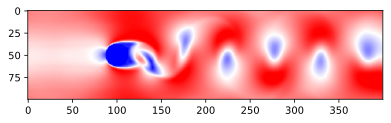

In [ ]:
from tqdm import tqdm

Nt = 10000
skip = 50
for it in tqdm(range(Nt)):
    rho = np.sum(boltzmannf, axis=2)  # density
    ux = np.sum(boltzmannf * veloI, axis=2) / rho  # x-velocity
    uy = np.sum(boltzmannf * veloJ, axis=2) / rho  # y-velocity

    # Boundary conditions: bounce-back for the cylinder
    ux[cylinder] = 0
    uy[cylinder] = 0
    boltzmannf[cylinder, :] = boltzmannf[cylinder, :][:,[0, 3, 4, 1, 2, 7, 8, 5, 6]]

    # Compute equilibrium distribution function
    boltzmannfeq = np.zeros_like(boltzmannf)
    for i in range(Nv):
        cdot = veloI[i] * ux + veloJ[i] * uy
        boltzmannfeq[:, :, i] = rho * weights[i] * (1 + 3 * cdot + 9/2 * cdot**2 - 3/2 * (ux**2 + uy**2))

    # collection step
    boltzmannf = boltzmannf + (boltzmannfeq - boltzmannf) / tau

    # Streaming step
    for i in range(Nv):
        boltzmannf[:, :, i] = np.roll(boltzmannf[:, :, i],
                                      (veloI[i], veloJ[i]),
                                      axis=(0, 1))
    # # Absorption boundary condition
    # boltzmannf[-1, :, [2, 5, 6]] = boltzmannf[-2, :, [2, 5, 6]]
    # boltzmannf[0, :, [4, 7, 8]] = boltzmannf[1, :, [4, 7, 8]]
    boltzmannf[0, :, [2, 5, 6]] = boltzmannf[1, :, [2, 5, 6]]
    boltzmannf[-1, :, [4, 7, 8]] = boltzmannf[-2, :, [4, 7, 8]]
    # Visualization
    if it % skip == 0:

        plt.imshow(np.sqrt(ux**2 + uy**2).T, cmap='bwr',
                   vmin = 0, vmax = 0.18)
        
        # plt.imshow(rho.T, cmap='bwr',vmin = 0, vmax = 0.18)

        # plot the vorticity
        # plt.imshow((np.gradient(uy, axis=0) - np.gradient(ux, axis=1)).T,
        #            cmap='bwr', vmin = -0.08, vmax = 0.08)

        # plt.colorbar(orientation='horizontal') 
        # plt.title(f'Timestep {it}')
        plt.pause(.01)
        clear_output(wait=True)

Well, through the above code, you might find it hard to figure out under what physical parameters this case is going on. This is the multi-scale essence of the lattice Boltzmann method.

In this case, 
- $\Delta x = \tilde{\xi}\Delta t, \tilde{\xi} = \sqrt{\frac{3k_{\rm B}T}{m}}$,
- $\tau' = 0.53 \Rightarrow \left(\tau' - \frac{1}{2}\right)\Delta t = \tau = \frac{\nu m}{k_{\rm B} T} \Rightarrow \nu = \left( \tau' - \frac{1}{2} \right) \Delta t \frac{k_{\rm B} T}{m}$.

Given an appropriate choice of $\Delta t$ can we determine the physical parameters in this case.

Let's choose an appropriate one. We first rewrite the expression of $\tilde{\xi}$:
$$
\tilde{\xi} = \sqrt{\frac{3k_{\rm B}T}{m}} = \sqrt{\frac{3(k_{\rm B}N_{\rm A})T}{M}}.
$$

where
- $k_{\rm B} N_{\rm A}$ is the ideal gas constant,
- $M$ is the molar mass of the gas.

Given a room temperature and the air, we can calculate the $\tilde{\xi}$

In [7]:
import astropy.constants as const
import astropy.units as units

R = const.k_B * const.N_A
# R = const.R # is also okey. 
M = 29 * units.g/units.mol
T = (25 + 273.15)*units.K  # temperature in Kelvin
ref_vel = np.sqrt(3*R*T/M).si
ref_vel

<Quantity 506.40283436 m / s>

Choose $\Delta x = 0.01~{\rm m}$, so that our region is $1~{\rm m} \times 4~{\rm m}$. Then we have our $\Delta t$ calculated.

In [8]:
dx = 0.01 * units.m
dt = dx / ref_vel
dt

<Quantity 1.97471249e-05 s>

Finally, the kinetic viscosity $\nu$ can be calculated.

In [9]:
nu = ((tau - .5) * dt * R * T / M).si
nu

<Quantity 0.05064028 m2 / s>